In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [2]:
from imputation import imputed_vals, run, imputed_sqr_err
from utils.forgetter import forget_random_col_per_sample_2
from utils.noise_utils import add_noise_to_column

In [3]:
seed = 42

In [4]:
random_state = np.random.RandomState(seed)
random_generator = np.random.default_rng(seed)

In [5]:
qualitative_cols_f = open('data/qualitative_cols.json', 'r')
categorical_cols_f = open('data/categorical_cols.json', 'r')

In [6]:
complete_vals_df = pd.read_csv("data/5-train_df.csv", index_col="Unnamed: 0") 
remove_vals_df = pd.read_csv("data/5-test_df.csv", index_col="Unnamed: 0") 
missing_vals_idxs = list(remove_vals_df.index)

In [7]:
sel_qual_cols = json.load(qualitative_cols_f)
sel_cat_cols = json.load(categorical_cols_f)

In [8]:
weight_map = {
    "age" : 1,
    "T3"  : 1,
    "T4U" : 1,
    "TSH" : 1,
    "TT4" : 1,
    "FTI" : 1
}

In [9]:
complete_vals_df

,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
7825,46.0,2.3,0.87,103.0,90.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2628,34.0,4.2,1.94,110.0,213.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2935,71.0,2.1,0.91,135.0,123.0,0.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,41.0,0.4,1.46,6.6,9.7,53.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3832,49.0,1.5,1.11,92.0,101.0,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,68.0,1.3,0.82,102.0,84.0,24.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7212,52.0,1.9,0.62,127.0,79.0,1.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6551,73.0,1.3,0.90,48.0,43.0,2.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2636,68.0,2.2,0.86,136.0,117.0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
noise_range = range(0, 10, 2)

In [11]:
noisy_df_dict = dict()
noisy_df_dict[0] = complete_vals_df
for i in noise_range:
    if i != 0:
        noisy_vals_df = complete_vals_df.copy()
        for col in sel_qual_cols:
            noisy_vals_df[col] = add_noise_to_column(complete_vals_df, col, i / 10)
        
        noisy_df_dict[i] = noisy_vals_df

In [12]:
noisy_df_dict[0]

,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
7825,46.0,2.3,0.87,103.0,90.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2628,34.0,4.2,1.94,110.0,213.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2935,71.0,2.1,0.91,135.0,123.0,0.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,41.0,0.4,1.46,6.6,9.7,53.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3832,49.0,1.5,1.11,92.0,101.0,2.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,68.0,1.3,0.82,102.0,84.0,24.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7212,52.0,1.9,0.62,127.0,79.0,1.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6551,73.0,1.3,0.90,48.0,43.0,2.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2636,68.0,2.2,0.86,136.0,117.0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
missing_vals_df = dict()
missing_col_map = dict()
missing_vals_idxs = dict()
picked_cols = dict()

real_df = dict()
curr_df = dict()

for i in noise_range:
    missing_vals_df[i], missing_col_map[i], missing_vals_idxs[i], picked_cols[i] = forget_random_col_per_sample_2(remove_vals_df, weight_map, random_generator)

    real_df[i] = pd.concat([noisy_df_dict[i], remove_vals_df])
    curr_df[i] = pd.concat([noisy_df_dict[i], missing_vals_df[i]])
    
    display(missing_vals_df[i])

,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
3196,76.0,0.5,0.85,153.0,NaN,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1736,57.0,1.8,NaN,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1836,86.0,2.0,0.62,NaN,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4819,37.0,2.3,0.94,72.0,NaN,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4300,NaN,2.0,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,NaN,1.8,0.94,97.0,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8024,NaN,2.6,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4111,24.0,2.3,1.09,67.0,73.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2694,NaN,1.9,0.87,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
3196,NaN,0.5,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1736,57.0,1.8,NaN,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1836,86.0,2.0,0.62,126.0,NaN,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4819,NaN,2.3,0.94,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4300,63.0,2.0,1.18,129.0,152.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,NaN,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8024,26.0,2.6,0.89,NaN,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4111,NaN,2.3,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2694,70.0,1.9,NaN,100.0,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
3196,76.0,0.5,NaN,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1736,57.0,NaN,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1836,86.0,NaN,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4819,37.0,2.3,0.94,72.0,NaN,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4300,63.0,2.0,NaN,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,97.0,91.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8024,26.0,NaN,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4111,24.0,NaN,1.09,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2694,70.0,1.9,0.87,NaN,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
3196,76.0,0.5,NaN,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1736,57.0,1.8,1.38,59.0,81.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1836,86.0,2.0,NaN,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4819,37.0,2.3,0.94,72.0,68.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4300,63.0,2.0,NaN,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,NaN,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8024,NaN,2.6,0.89,107.0,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4111,24.0,2.3,1.09,67.0,73.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2694,70.0,1.9,0.87,NaN,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,age,T3,T4U,FTI,TT4,TSH,on_antithyroid_meds,on_thyroxine,thyroid_surgery,sick,tumor,goitre,pregnant,I131_treatment,lithium,sex,psych
3196,76.0,NaN,0.85,153.0,130.0,6.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1736,57.0,NaN,1.38,59.0,81.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1836,86.0,NaN,0.62,126.0,79.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4819,37.0,2.3,NaN,72.0,68.0,2.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4300,63.0,NaN,1.18,129.0,152.0,1.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6266,39.0,1.8,0.94,NaN,91.0,1.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8024,26.0,2.6,0.89,NaN,95.0,3.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4111,24.0,2.3,NaN,67.0,73.0,1.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2694,70.0,1.9,0.87,NaN,87.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
neighbours = 14

In [15]:
knn_imputed_df = dict()
for i in noise_range:
    knn_imputed_df[i], _ = run(real_df[i], curr_df[i], missing_vals_idxs[i], picked_cols[i], "kNN",
                                config={
                                    "n_neighbors": neighbours
                                }, estimator_config={})

In [16]:
wknn_imputed_df = dict()
for i in noise_range:
    wknn_imputed_df[i], _ = run(real_df[i], curr_df[i], missing_vals_idxs[i], picked_cols[i], "WkNN",
                            config={
                                "n_neighbors": neighbours
                            }, estimator_config={})

In [17]:
iters = 100

In [18]:
mice_imputed_df = dict()
for i in noise_range:
    mice_imputed_df[i], _ = run(real_df[i], curr_df[i], missing_vals_idxs[i], picked_cols[i], "MICE",
                            config={
                                "random_state": random_state, 
                                "max_iter": iters
                            }, estimator_config={})

In [19]:
mice_rf_imputed_df = dict()
for i in noise_range:
    mice_rf_imputed_df[i], _ = run(real_df[i], curr_df[i], missing_vals_idxs[i], picked_cols[i], "MICE RF",
                                config={
                                    "random_state": random_state, 
                                    "max_iter": iters
                                }, estimator_config={
                                    "n_estimators": 300,
                                    "max_depth": 10,
                                    "bootstrap": True,
                                    "max_samples": 0.5,
                                    "random_state": random_state,
                                })

In [20]:
knn_sqr_err_dict = dict()
for i in noise_range:
    knn_sqr_err_dict[i] = imputed_sqr_err(real_df[i].columns, knn_imputed_df[i])

In [21]:
wknn_sqr_err_dict = dict()
for i in noise_range:
    wknn_sqr_err_dict[i] = imputed_sqr_err(real_df[i].columns, wknn_imputed_df[i])

In [22]:
mice_sqr_err_dict = dict()
for i in noise_range:
    mice_sqr_err_dict[i] = imputed_sqr_err(real_df[i].columns, mice_imputed_df[i])

In [23]:
mice_rf_sqr_err_dict = dict()
for i in noise_range:
    mice_rf_sqr_err_dict[i] = imputed_sqr_err(real_df[i].columns, mice_rf_imputed_df[i])

In [24]:
real_cols = [col + " (real)" for col in sel_qual_cols]
imputed_cols = [col + " (imputed)" for col in sel_qual_cols]

In [25]:
def sturges(size : int) -> int:
    return 1 + math.ceil(math.log2(size))

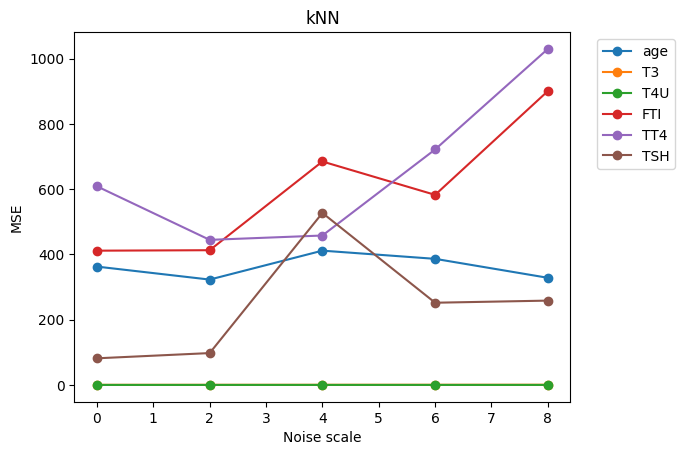

In [26]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in knn_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in knn_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("kNN")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

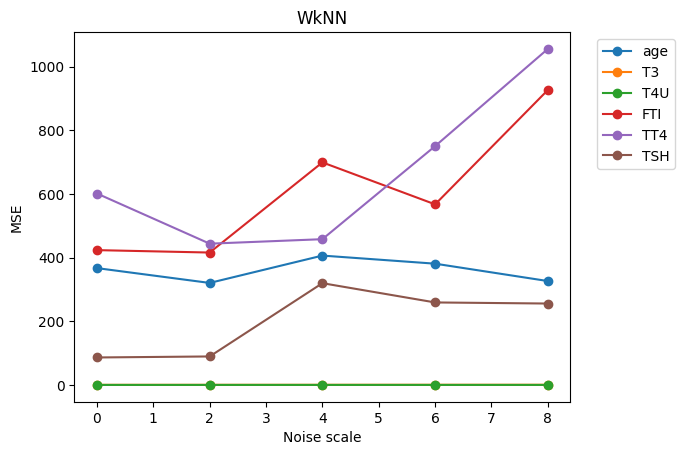

In [27]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in wknn_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in wknn_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("WkNN")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

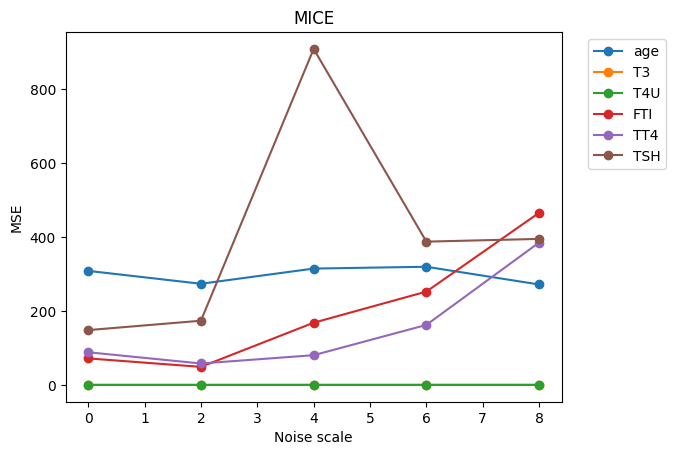

In [28]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in mice_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in mice_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("MICE")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

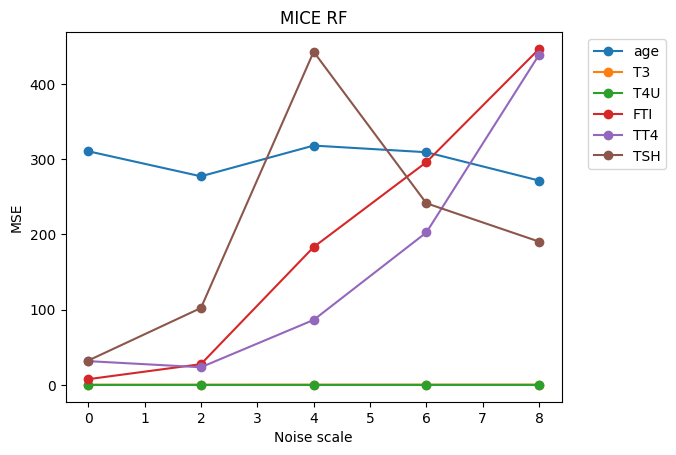

In [29]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in mice_rf_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in mice_rf_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("MICE RF")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

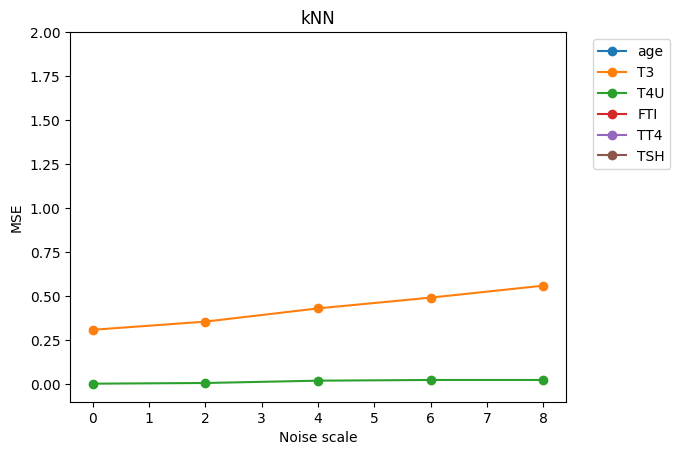

In [30]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in knn_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in knn_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("kNN")

plt.ylim(-0.1, 2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

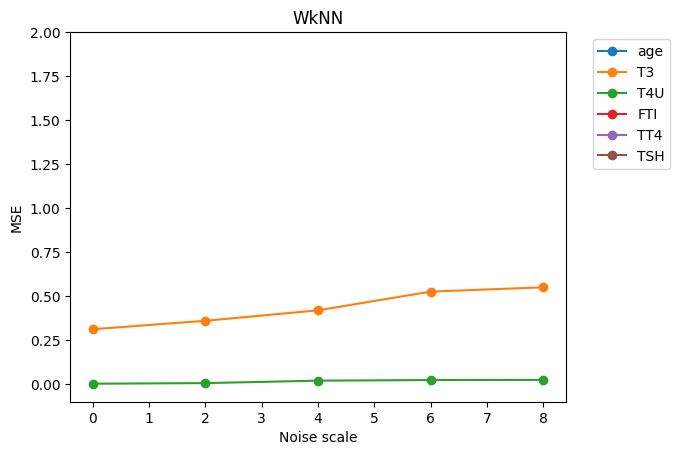

In [31]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in wknn_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in wknn_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("WkNN")

plt.ylim(-0.1, 2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

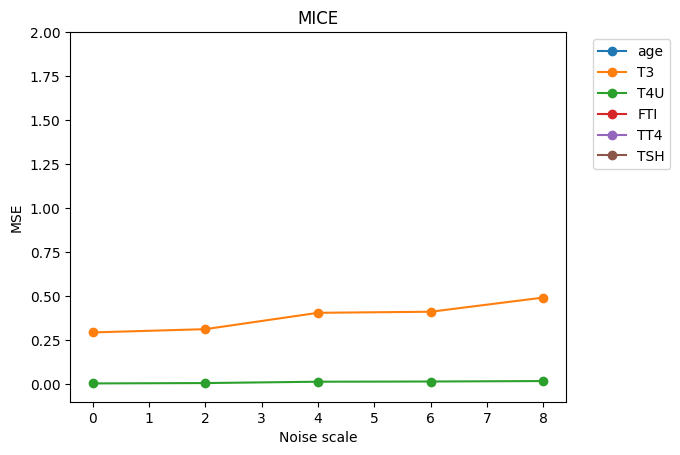

In [32]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in mice_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in mice_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("MICE")

plt.ylim(-0.1, 2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

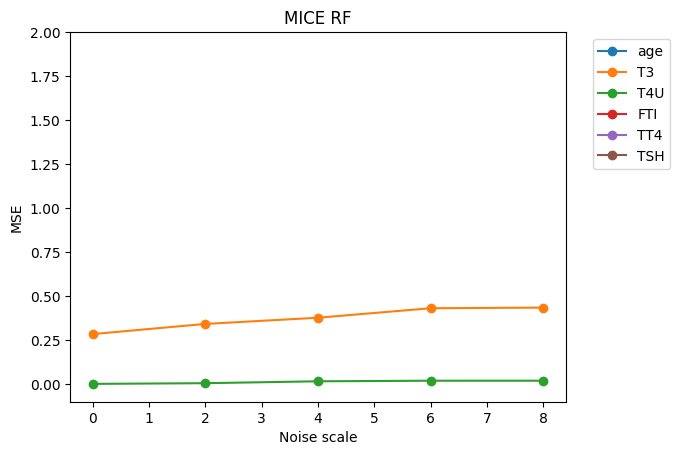

In [33]:
for col in real_df[0].columns:
    if col not in sel_cat_cols:
        X = [k for (k, _) in mice_rf_sqr_err_dict.items()]
        Y = [v[col] for (k, v) in mice_rf_sqr_err_dict.items()]

        plt.plot(X, Y, label=col, marker="o")
        plt.xlabel("Noise scale")
        plt.ylabel("MSE")
        plt.title("MICE RF")

plt.ylim(-0.1, 2)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [34]:
methods_map = {
    "kNN": knn_imputed_df,
    "WkNN": wknn_imputed_df,
    "MICE": mice_imputed_df,
    "MICE RF": mice_rf_imputed_df
}

In [35]:
imputed_var_map = dict()
real_var_map = dict()
for method_name, method_df in methods_map.items():
    imputed_var_map[method_name], real_var_map[method_name] = imputed_vals(real_df[0].columns, method_df[0])

In [36]:
cfs_mat_cols = ["T3", "TT4", "TSH"]
expected_dict = dict()
predicted_dict = dict()

In [37]:
def map_t3(val):
    if val < 1.2:
        return "0-1.2"
    elif val >= 1.2 and val <= 3.1:
        return "1.2-3.1"
    return "3.1+" 

In [38]:
def map_tt4(val):
    if val < 58:
        return "0-58"
    elif val >= 58 and val <= 154:
        return "58-154"
    return "154+" 

In [39]:
def map_tsh(val):
    if val < 0.4:
        return "0-0.4"
    elif val >= 0.4 and val <= 5:
        return "0.4-5"
    return "5+" 

In [40]:
mapper = {
    "T3": map_t3,
    "TT4": map_tt4,
    "TSH": map_tsh
}

In [41]:
label_map = {
    "T3": ["0-1.2", "1.2-3.1", "3.1+"],
    "TT4": ["0-58", "58-154", "154+"],
    "TSH": ["0-0.4", "0.4-5", "5+"]
}

In [42]:
for method_name in methods_map.keys():
    predicted_dict[method_name] = dict()
    expected_dict[method_name] = dict()
    for col in cfs_mat_cols:
        predicted_dict[method_name][col] = dict()
        expected_dict[method_name][col] = dict()
        for i in range(len(imputed_var_map[method_name][col])):
            predicted_dict[method_name][col][i] = mapper[col](imputed_var_map[method_name][col][i])
            expected_dict[method_name][col][i] = mapper[col](real_var_map[method_name][col][i])

In [43]:
from confusion_matrix import calculate_relative_confusion_matrix, plot_confusion_matrix, calculate_confusion_matrix

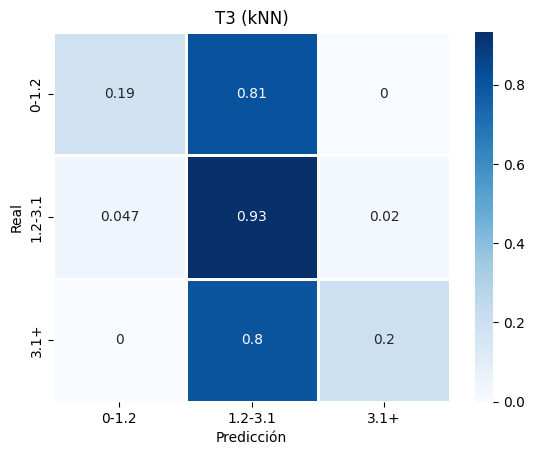

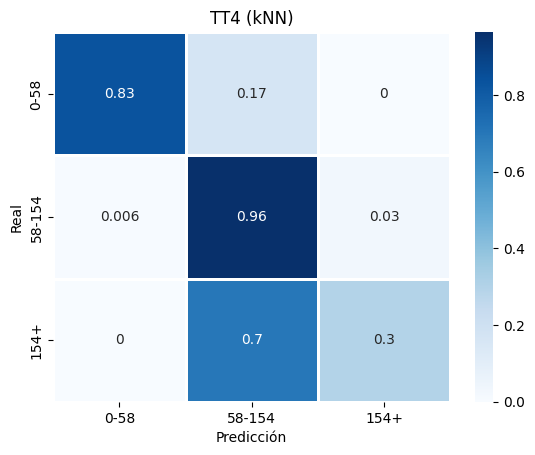

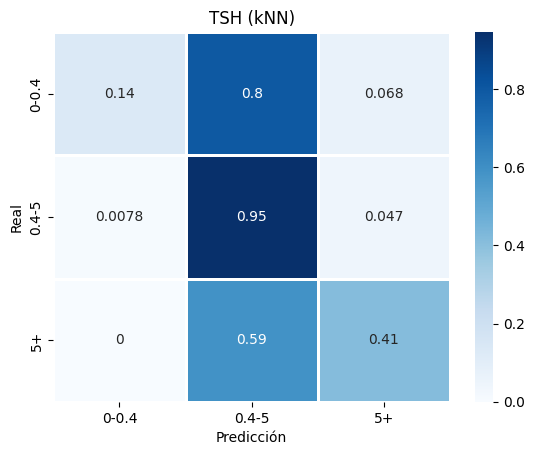

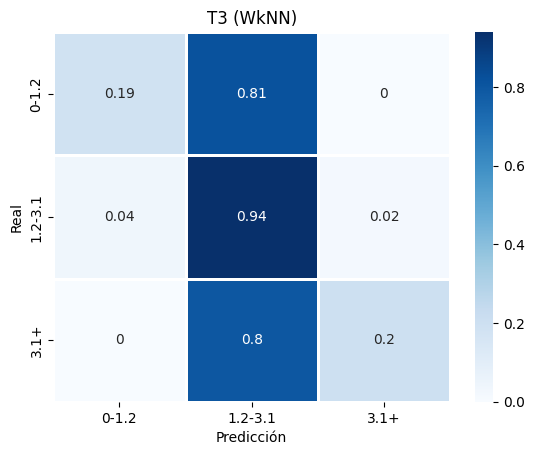

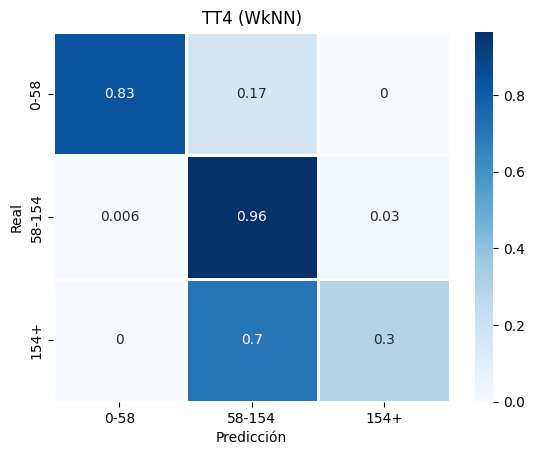

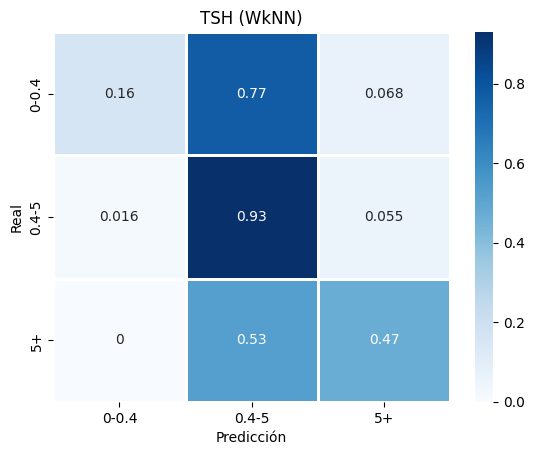

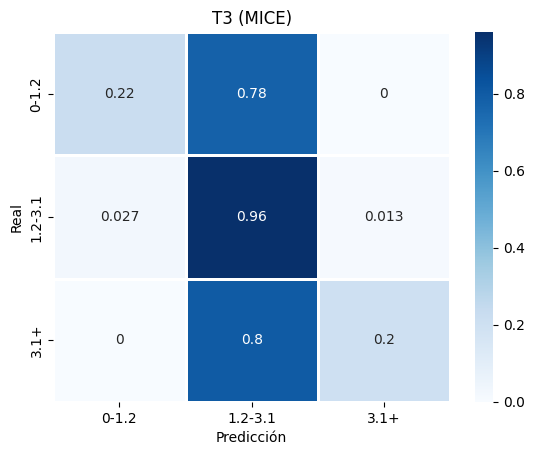

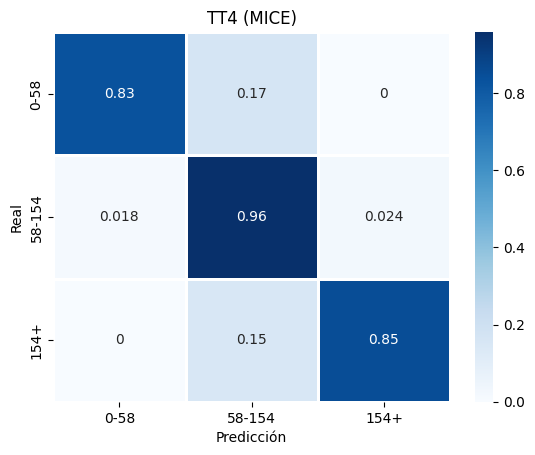

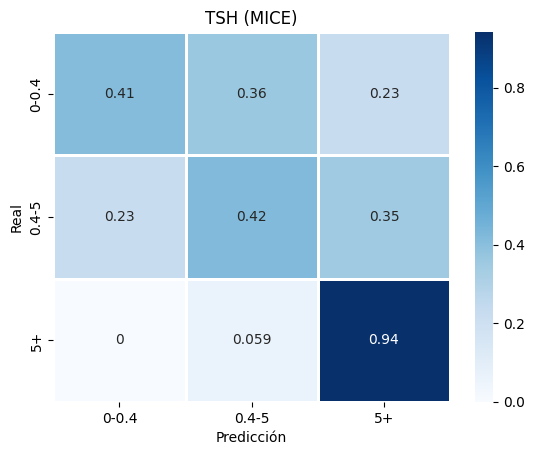

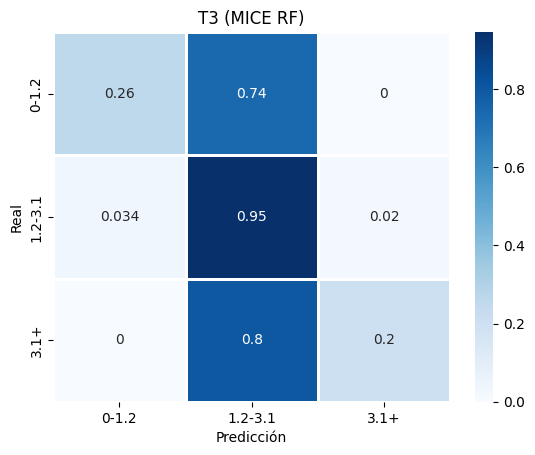

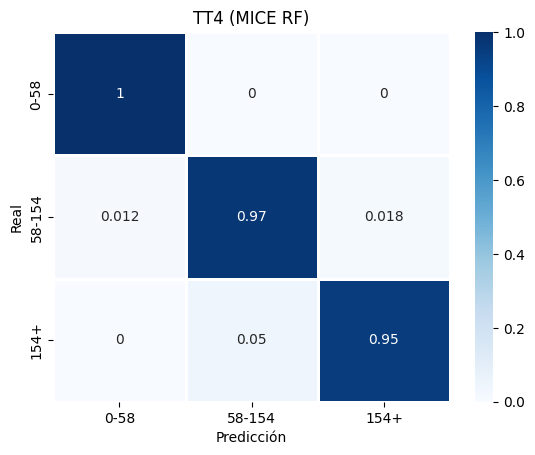

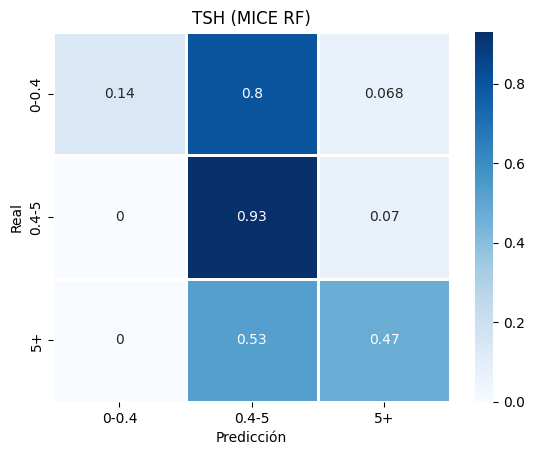

In [44]:
rel_cfs_mats = dict()
for method_name in methods_map.keys():
    rel_cfs_mats[method_name] = dict()
    for col in cfs_mat_cols:
        rel_cfs_mats[method_name][col] = calculate_relative_confusion_matrix(np.array(label_map[col]), predicted_dict[method_name][col], expected_dict[method_name][col])
        plot_confusion_matrix(rel_cfs_mats[method_name][col], col + " ({})".format(method_name), format=".2g")

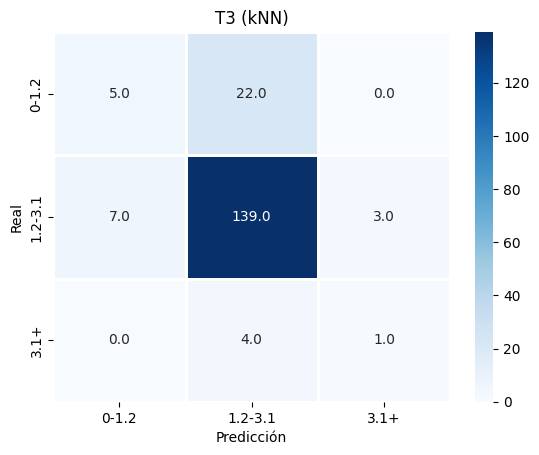

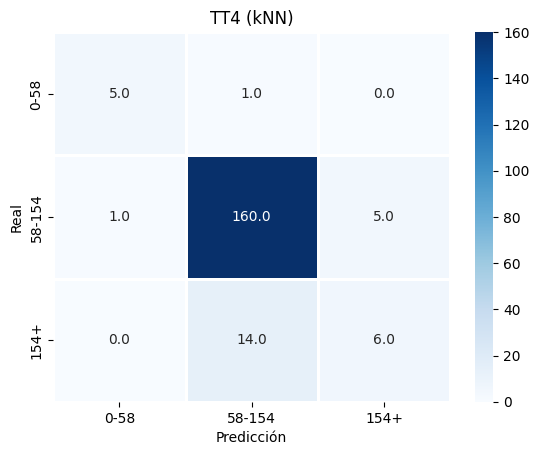

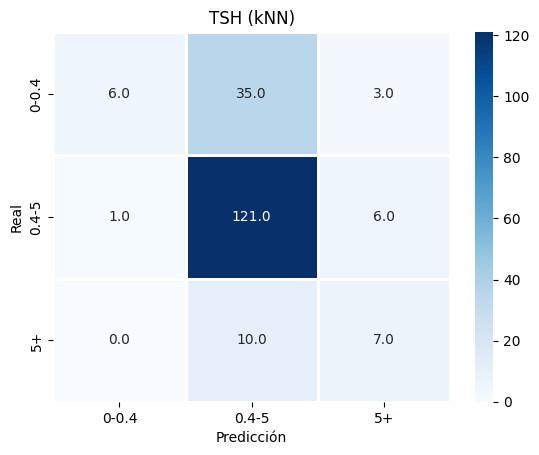

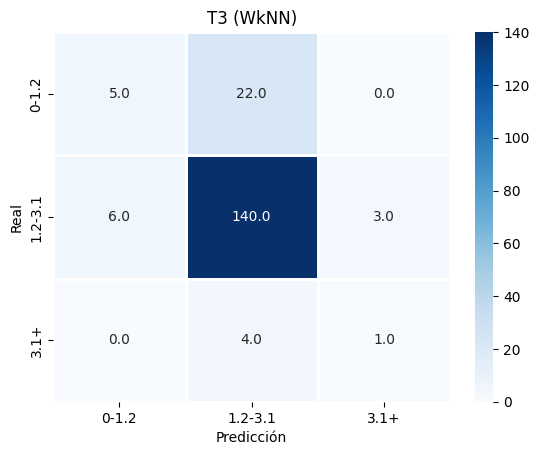

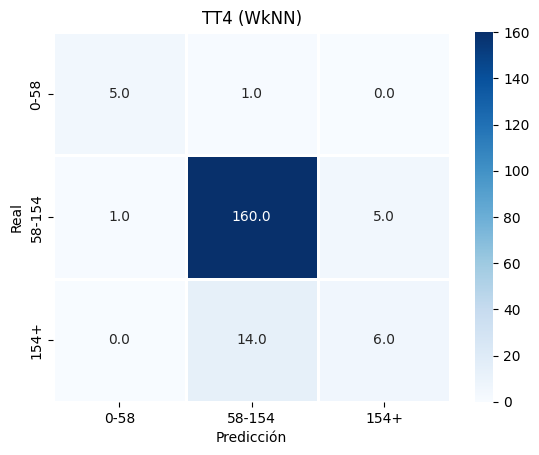

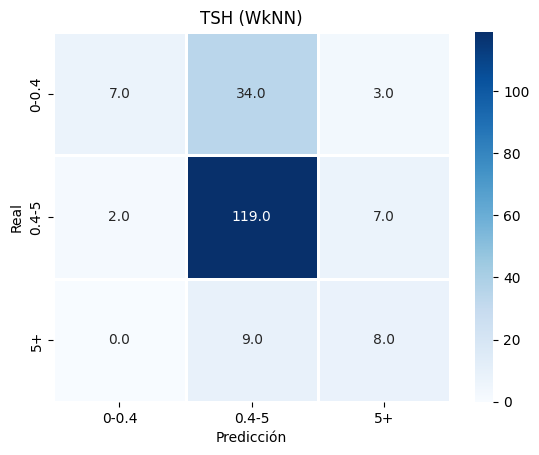

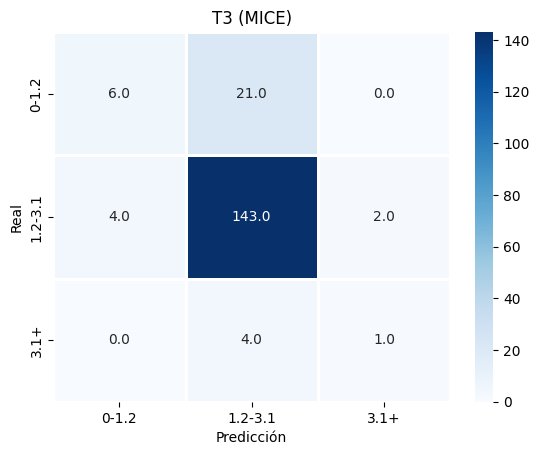

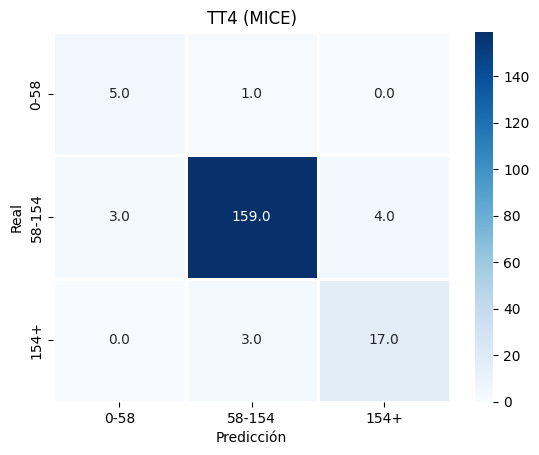

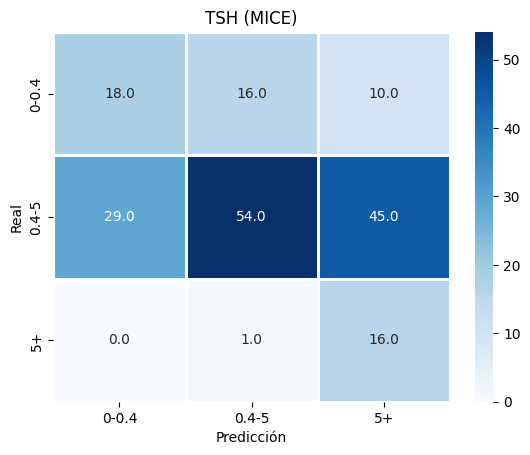

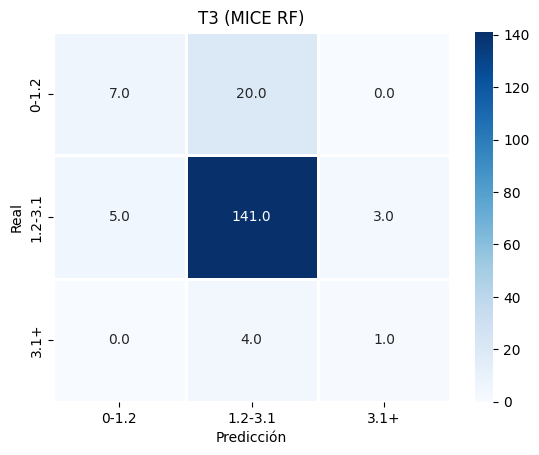

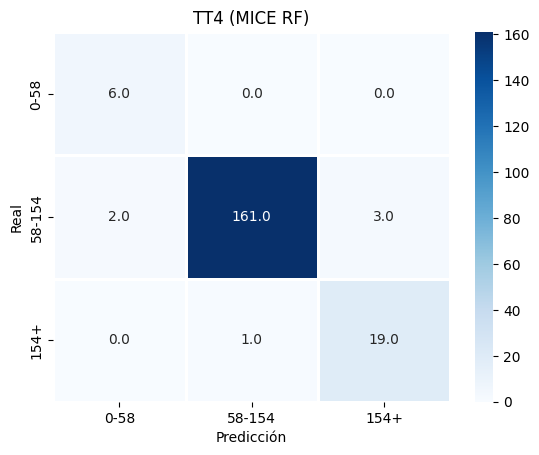

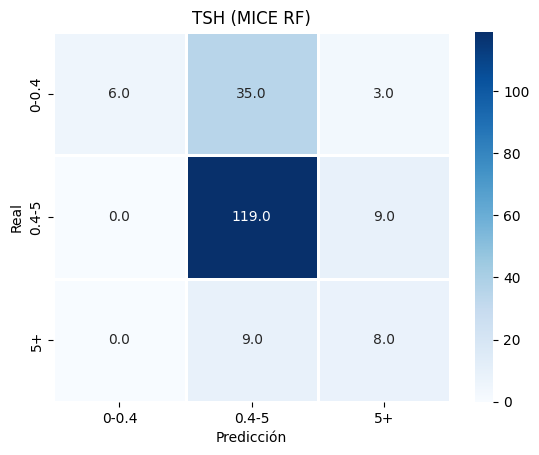

In [45]:
cfs_mats = dict()
for method_name in methods_map.keys():
    cfs_mats[method_name] = dict()
    for col in cfs_mat_cols:
        cfs_mats[method_name][col] = calculate_confusion_matrix(np.array(label_map[col]), predicted_dict[method_name][col], expected_dict[method_name][col])
        plot_confusion_matrix(cfs_mats[method_name][col], col + " ({})".format(method_name))